# Unsupervised SRBM

We can train RBM unsupervised.

Originally, we use data and model distribution to maximize the loglikelihood.

\begin{align}
{\rm Max} \left\langle \ln ( q(\phi) ) \right\rangle_{p}
\end{align}

Instead we can use generated data to estimate p.

\begin{align}
\mathcal{L} &= {\rm Max} \left\langle \ln ( p(\phi) ) \right\rangle_{q} \\
&= {\rm Max} \left\langle -S_{\phi}(\phi) - \ln Z \right\rangle
\end{align}

\begin{align}
\frac{\partial \mathcal{L}}{\partial w_{ia}} &= -\frac{\partial \langle S_{\phi}(\phi^{\rm rbm}) \rangle_{q}}{\partial w_{ia}}
 - \langle \phi_i \phi_j w_{ja} \rangle_{q} \\
 &= \left\langle S_{\phi}(\phi) \frac{\partial S_{\rm RBM}}{\partial w_{ia}} \right\rangle - \langle \phi_i \phi_j w_{ja} \rangle \\
 &= \left\langle S_{\phi} (\phi) \phi_i \phi_j w_{ja} \right\rangle - \langle \phi_i \phi_j w_{ja} \rangle
\end{align}

or

\begin{align}
\frac{\partial \mathcal{L}}{\partial w_{ia}} &= \langle \phi_i \phi_j w_{ja} \rangle_{q}
 - \langle \phi_i \phi_j w_{ja} \rangle_{q} \\
 &= K^{-1}_{\phi, ij}w_{ja} - K^{-1}_{\rm RBM, ij} w_{ja}
\end{align}

We have to know the expression for one-point and two point function.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

import random

# Change accordingly to your directory structure
sys.path.append('/Users/chanju/Dropbox/Lab/SU/workspace/Git/SRBM/')
import RBM

In [24]:
N = 10

In [25]:
conf_id = 'phi_1d_10N_2m'
# data_file = np.load('../datas/scalar_field/phi_1d_10N_2m_2/phi_1d_10N_2m_2.npy')
data_file = np.load('../datas/scalar_field/'+conf_id+'/'+conf_id+'.npy')
n_data = len(data_file)

In [26]:
def S(field, m):
    N = len(field)
    s = 0.
    for i in range(N):
        s += -0.5*field[i]*(field[(i+1)%N] + field[(i-1)%N] - (2.+ m[i]**2)*field[i])

    return s/N

def S_fast(field,m=2.):
    N = field.shape[0]
    s = m**2 * field**2
    s += 2.*field**2
    s -= field*torch.roll(field,-1)
    s -= field*torch.roll(field,1)
    return torch.sum(0.5*s)/N

In [27]:
# True matrix
m = 2
W = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if i==j:
            W[i][j] = 2 + m**2
#             W[i][j] = 2.
        elif (i % N == (j+1) %N) or (i % N == (j-1) %N):
            W[i][j] = -1
print(W)
K_phi = W

[[ 6. -1.  0.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  6. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  6. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  6. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  6. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  6. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  6. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  6. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  6. -1.]
 [-1.  0.  0.  0.  0.  0.  0.  0. -1.  6.]]


$w w^T = -K_{\phi} + m^2$

In [28]:
# Cholesky solution
W_phi = np.linalg.cholesky(-K_phi + np.diag([5**2]*N))

In [29]:
-K_phi + np.diag([5**2]*N)

array([[19.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1., 19.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., 19.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., 19.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., 19.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., 19.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., 19.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., 19.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 19.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 19.]])

In [30]:
W_phi @ W_phi.T

array([[ 1.90000000e+01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 1.00000000e+00,  1.90000000e+01,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.37242037e-19],
       [ 0.00000000e+00,  1.00000000e+00,  1.90000000e+01,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -4.30756862e-20],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.90000000e+01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.15303820e-20],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.90000000e+01,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.

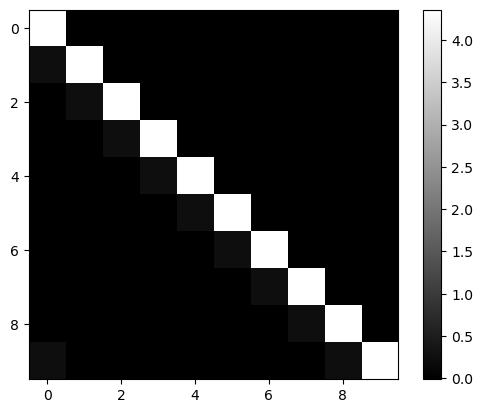

In [31]:
plt.imshow(W_phi, cmap='gray')
plt.colorbar()
plt.show()

In [32]:
W_phi

array([[ 4.35889894e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.29415734e-01,  4.35285750e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  2.29734146e-01,  4.35284071e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.29735032e-01,
         4.35284066e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.29735035e-01,  4.35284066e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.

In [33]:
N = 10
# Initialization scheme.
# Initialize w with Cholesky solution W_phi and mass=5 sigma=1
init_cond = {'w':torch.DoubleTensor(W_phi.copy()),'m':5., 'sig':1.}
# init_cond = {'m':2.3, 'sig':1.}

# Reproducibility
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

# Initialize SRBM
rbm = RBM.SRBM(n_v=N,n_h=N,k=10,init_cond=init_cond)

# For autograd if implimented
# train_op = optim.SGD(rbm.parameters(),1e-7)
# train_op = optim.Adam(rbm.parameters(),1e-5)

# Check initial coupling matrix
print(rbm.w)

# Training parameters
lr = 1e-1
epochs = 1200
batch_size = 64

# Initial field.
# Cold start
init_field = torch.ones((batch_size,N))

# Train the model
history = rbm.unsup_fit(K_phi, S_fast, epochs, lr, batch_size)

Initializing model SRBM-230321_153520
Parameter containing:
tensor([[ 4.3589e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.2942e-01,  4.3529e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  2.2973e-01,  4.3528e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.2974e-01,  4.3528e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.2974e-01,  4.3528e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.2974e-01,
          4.3528e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00

# Training result

In [34]:
plot_dir = '../plots/'
model_name ='normal'

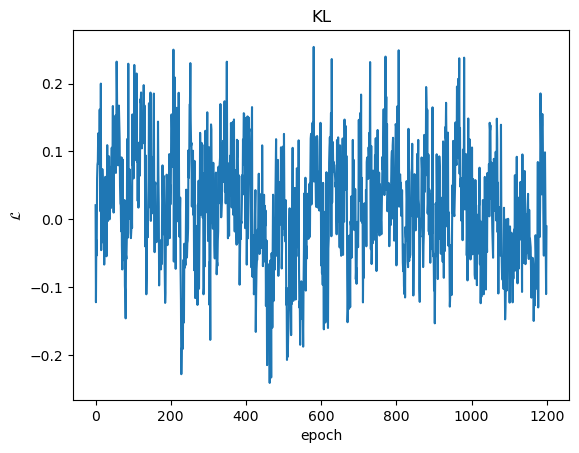

In [35]:
# Loss function
plt.plot(np.arange(len(history['loss'])),history['loss'])
plt.title('KL')
plt.xlabel('epoch')
plt.ylabel(r'$\mathcal{L}$')
# plt.savefig(plot_dir+model_name+'_lc.jpg')
plt.show()

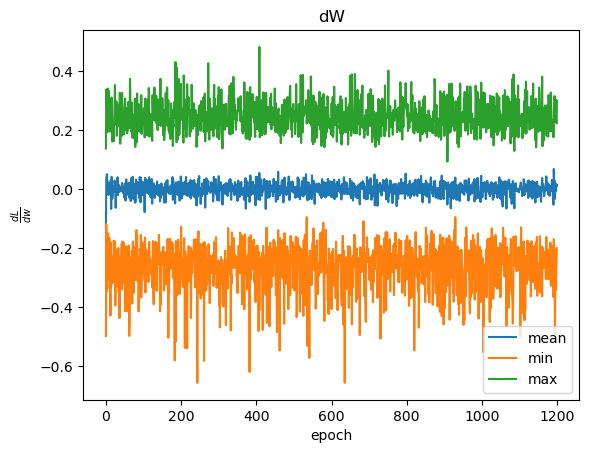

In [36]:
# Gradient
plt.plot(np.arange(len(history['dw'])),np.mean(np.mean(history['dw'], axis=1),axis=1), label='mean')
plt.plot(np.arange(len(history['dw'])),np.min(np.min(history['dw'], axis=1),axis=1), label='min')
plt.plot(np.arange(len(history['dw'])),np.max(np.max(history['dw'], axis=1),axis=1), label='max')
plt.title('dW')
plt.xlabel('epoch')
plt.ylabel(r'$\frac{d L}{dw}$')
plt.legend()
# plt.savefig(plot_dir+model_name+'_lc.jpg')
plt.show()

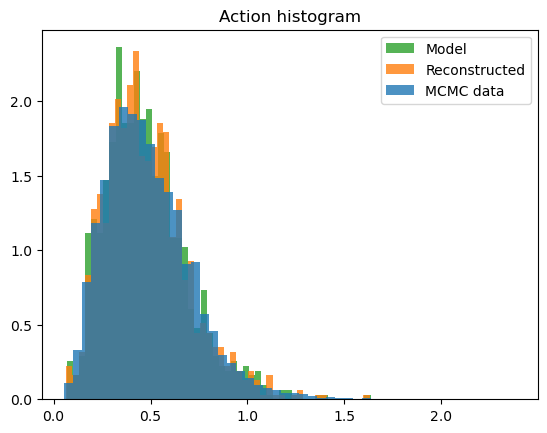

In [39]:
n_samples = 1000
recon_field = torch.ones((n_samples, N))
v_pred, v_, h_pred, _, v = rbm.forward(recon_field,n_samples)
n_samples = len(v)
S_true = np.zeros(n_data)
S_pred = np.zeros(n_samples)
S_K = np.zeros(n_samples)
M = m*np.ones(N)

for i in range(n_data):
    S_true[i] = S(data_file[i],M)

for i in range(n_samples):
    S_pred[i] = S(v_.data.numpy()[i],M)
    S_K[i] = -rbm.free_energy(v_[i:i+1]).data.numpy()/N
#     w_ = rbm.W.data.numpy().copy()
#     m_ = rbm.mass.data.numpy().copy()
#     sig_ = rbm.h_std
#     Kin = -sig_**2 *(w_.T @ w_)
#     Mss = np.diag(m_**2)m
#     s_ = 0.5 * v_pred.data.numpy()[i] @ (Kin + Mss) @ v_pred.data.numpy()[i].T/N
#     S_K[i] = s_

plt.hist(S_K, bins=50, density=True, color='C2', label='Model', alpha=0.8)
plt.hist(S_pred, bins=50, density=True, color='C1', label='Reconstructed', alpha=0.8)    
plt.hist(S_true, bins=50, density=True, color='C0', label='MCMC data', alpha=0.8)
plt.legend()
plt.title('Action histogram')
# plt.savefig(plot_dir+model_name+'_S.jpg')
plt.show()

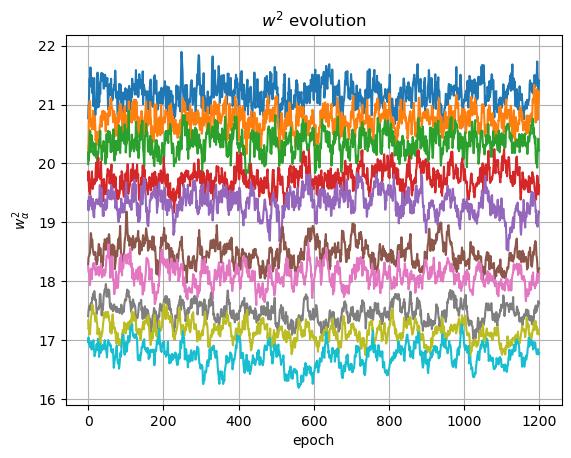

In [41]:
# SVD of coupling matrix squared
s_hist = np.zeros((epochs,N))
for i in range(epochs):
    _, s_, _ = np.linalg.svd(history['w'][i])
    s_hist[i] = s_

plt.plot(np.arange(epochs),s_hist**2)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}^2$')
plt.title(r'$w^2$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

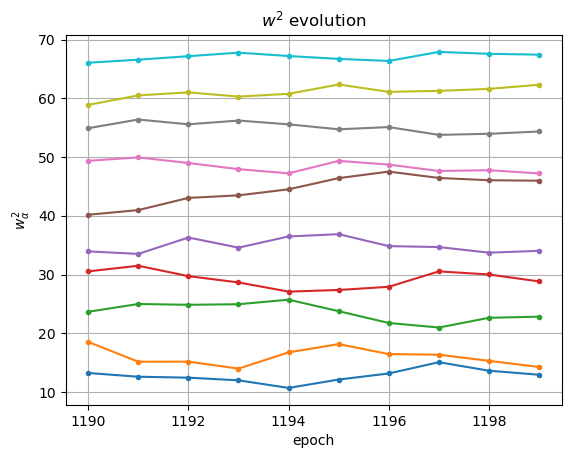

In [48]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:]**2, '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}^2$')
plt.title(r'$w^2$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

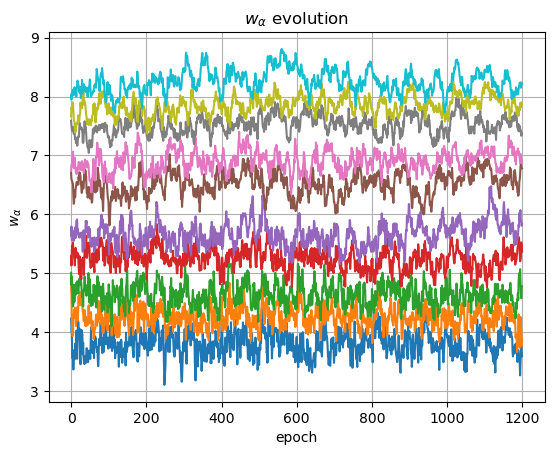

In [50]:
# SVD of coupling matrix not squared
plt.plot(np.arange(epochs),s_hist, '-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}$')
plt.title(r'$w_{\alpha}$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

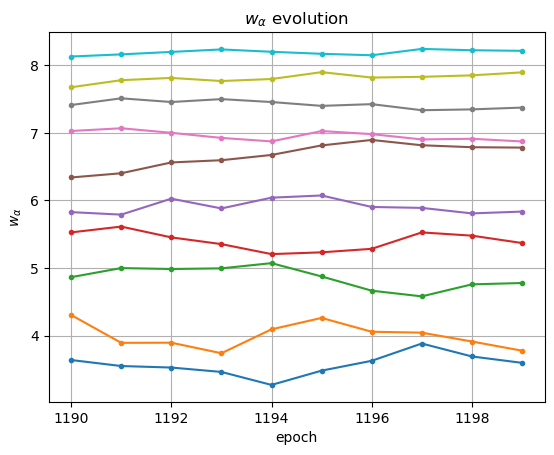

In [51]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:], '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}$')
plt.title(r'$w_{\alpha}$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

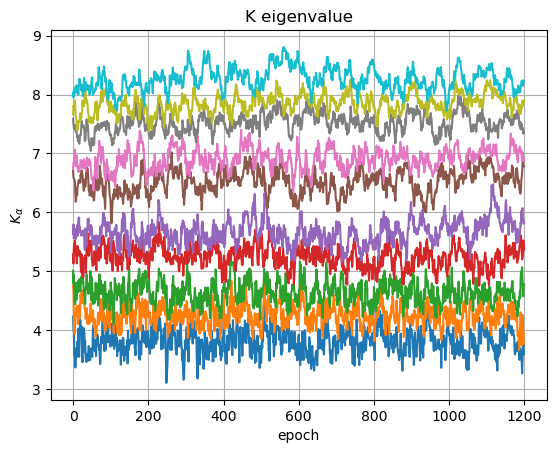

In [55]:
# Kernel SVD values
s_hist = np.zeros((epochs,N))
mu2 = np.diag(np.ones(N))

for i in range(epochs):
    WW_ = history['w'][i].T@history['w'][i]
    K_ = -rbm.sig**2 * WW_ + np.diag(history['m'][i]**2)
    if i ==0:
        K_i = K_.copy()
    s_ = np.sort(np.linalg.eigvals(K_))
    s_hist[i] = s_

plt.plot(np.arange(epochs),s_hist)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$K_{\alpha}$')
plt.title('K eigenvalue')
# plt.savefig(plot_dir+model_name+'_K.jpg')
plt.show()

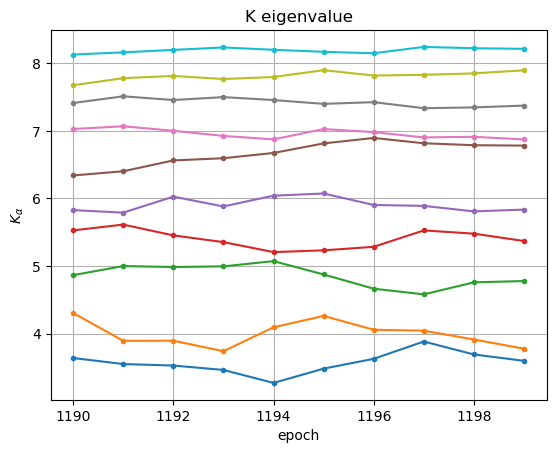

In [56]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:], '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$K_{\alpha}$')
plt.title('K eigenvalue')
# plt.savefig(plot_dir+model_name+'_K.jpg')
plt.show()

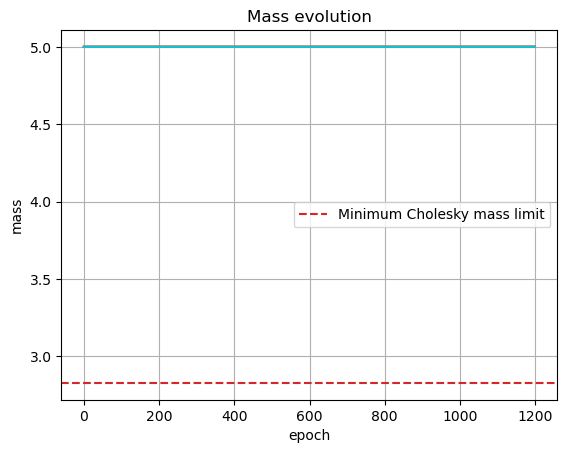

In [57]:
# Mass parameter of the model
plt.plot(np.arange(len(history['m'])),history['m'])
plt.axhline(np.sqrt(m**2 + 2. + 2.), ls='--', color='C3', label='Minimum Cholesky mass limit')
plt.title('Mass evolution')
plt.xlabel('epoch')
plt.ylabel('mass')
plt.legend()
plt.grid(True)
# plt.savefig(plot_dir+model_name+'_mass.jpg')
plt.show()

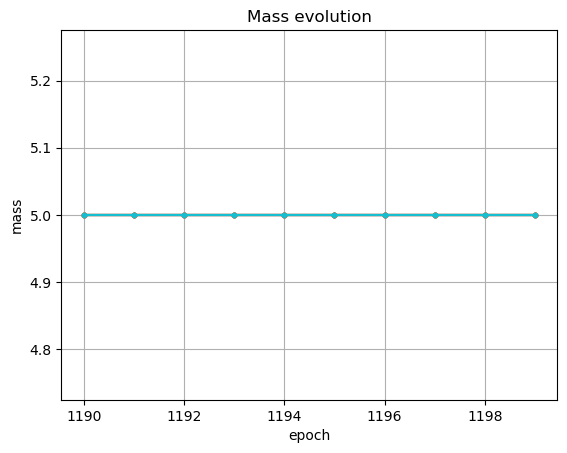

In [58]:
# Last few steps
plt.plot(np.arange(len(history['m']))[-10:],history['m'][-10:], '.-')
# plt.axhline(np.sqrt(m**2 + 2. + 2.), ls='--', color='C3', label='Minimum Cholesky mass limit')
plt.title('Mass evolution')
plt.xlabel('epoch')
plt.ylabel('mass')
# plt.legend()
plt.grid(True)
# plt.savefig(plot_dir+model_name+'_mass.jpg')
plt.show()

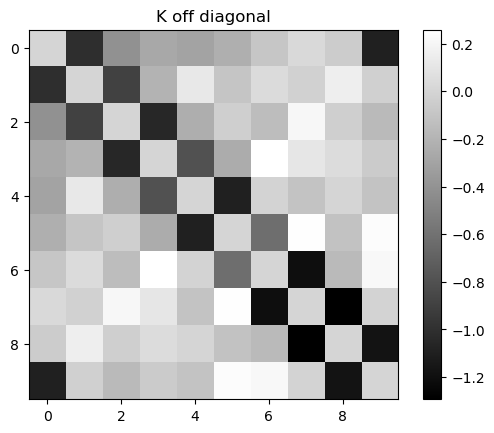

In [60]:
# K_rbm off diagonal part
Kin = (-rbm.sig**2 * (rbm.w.t() @ rbm.w)).data.numpy()
Mss = np.diag((rbm.m**2).data.numpy())
K = Kin + Mss

K_off = K - np.diag(np.diag(K))
plt.imshow(K_off, cmap='gray', vmax=K_off.max(), vmin=K_off.min())
plt.colorbar()
plt.title('K off diagonal')
# plt.savefig(plot_dir+model_name+'_K_img.jpg')
plt.show()

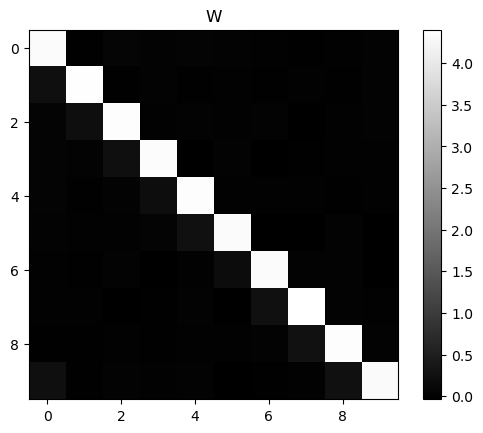

In [71]:
# Coupling matrix as image
w_rbm = rbm.w.data.numpy()
plt.imshow(w_rbm, cmap='gray')
plt.colorbar()
plt.title('W')
# plt.savefig(plot_dir+model_name+'_K_img.jpg')
plt.show()

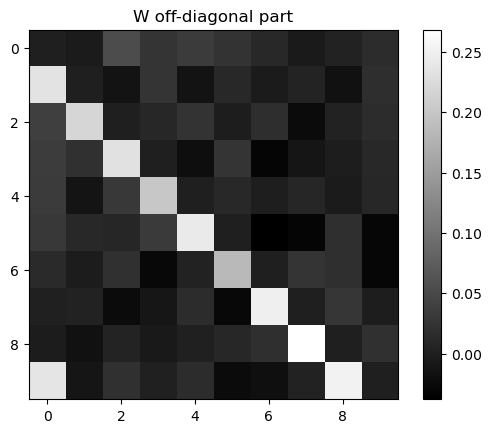

In [73]:
# Coupling matrix off-diagonal
w_rbm = rbm.w.data.numpy()
plt.imshow(w_rbm - np.diag(np.diag(w_rbm)), cmap='gray')
plt.colorbar()
plt.title('W off-diagonal part')
# plt.savefig(plot_dir+model_name+'_K_img.jpg')
plt.show()

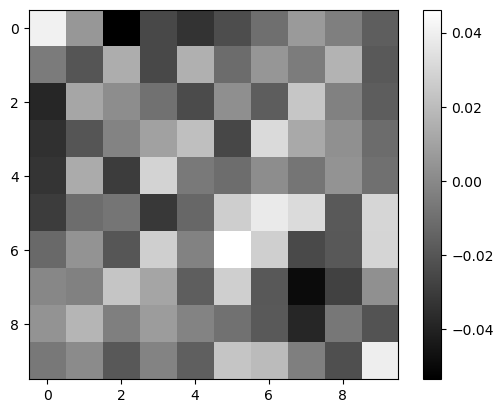

mean:  -0.0032972651096784124
std:  0.020970937438577197


In [96]:
# Difference between Choleski(initial) solution to the trained solution
diff = W_phi - w_rbm
plt.imshow(diff, cmap='gray')
plt.colorbar()
plt.show()

print('mean: ',np.mean(diff))
print('std: ',np.std(diff))

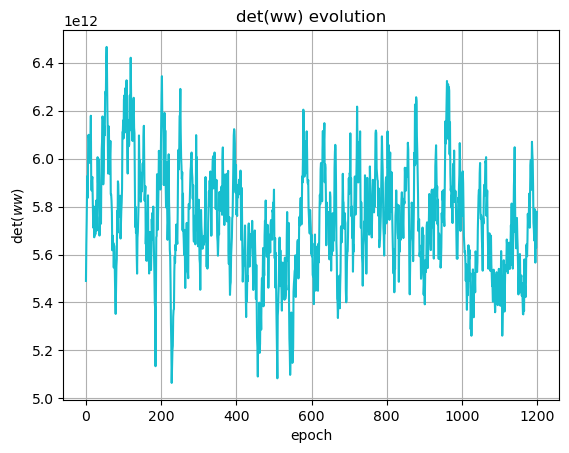

In [64]:
# Evolution of det(ww^T)
det_hist = np.zeros(epochs)
for i in range(epochs):
    det = np.linalg.det(history['w'][i].T @ history['w'][i])
    det_hist[i] = det

plt.plot(np.arange(epochs),det_hist,'C9')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'det($ww$)')
plt.title(r'det(ww) evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

# Scaling of K_RBM

In [65]:
# Least square fit
def loss(K, K_phi, Zk, b, r):
    return np.sum((K - Zk*K_phi - b - r)**2)

def dL_dZ(K, K_phi, Zk, b, r):
    return -np.sum(2.*(K - Zk*K_phi - b - r)*K_phi)

def dL_db(K, K_phi, Zk, b, r):
    return -np.sum(2.*(K - Zk*K_phi - b - r))

def dL_dr(K, K_phi, Zk, b, r):
    return -2.*(K - Zk*K_phi - b - r)

def get_scale(model, verbose=True):
    Kin = (-model.sig**2 * (model.w.t() @ model.w)).data.numpy()
    Mss = np.diag((model.m**2).data.numpy())
    K = Kin + Mss
    mu_ = model.m.data.numpy()
    Zk_gd = mu_.min()**2/(2.**2 + 4)

    np.random.seed(1234)
    r_seed = np.random.normal(0.,.01,size=K.shape) # ~ sigma^2
    r_gd = r_seed.T @ r_seed
    b_gd = 0.
    lr = 1e-5

    for i in range(10000):
        l = loss(K, K_phi, Zk_gd, b_gd, r_gd)
    #     print(l)
        dZ = lr * dL_dZ(K, K_phi, Zk_gd, b_gd, r_gd)
        db = lr * dL_db(K, K_phi, Zk_gd, b_gd, r_gd)
        dr = lr * dL_dr(K, K_phi, Zk_gd, b_gd, r_gd)

        Zk_gd -= dZ
        b_gd -= db
        r_gd -= dr
        if i%1000 == 0 and verbose:
            print(i, l, Zk_gd, b_gd)
            
    return Zk_gd, b_gd, r_gd, K

In [66]:
Zk, b, r, K = get_scale(rbm)

0 1705.0678533595328 3.1089170956397054 -0.001759772724729498
1000 3.2534953642276427 1.02436654136744 -0.07413675527270402
2000 2.9957537119199045 1.0190250372504037 -0.04236296080154569
3000 2.875438264403486 1.0183630100536143 -0.0376387588986015
4000 2.7626271098204804 1.0182650100437274 -0.036939034596142804
5000 2.654300518547501 1.0182504949731812 -0.036835396195417376
6000 2.5502228563744143 1.0182483450998134 -0.036820045981442166
7000 2.4502262071257905 1.0182480266752152 -0.03681777241230744
8000 2.3541505216532834 1.018247979512332 -0.036817435666733955
9000 2.2618420546300237 1.0182479725268871 -0.03681738579027334


In [92]:
Zk

1.0182479714925932

# Compare Kernel

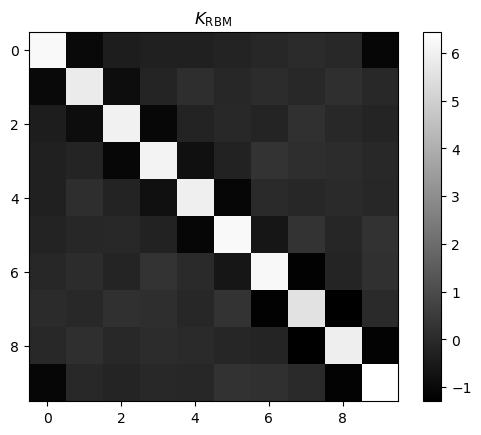

In [93]:
# Trained Kernel
plt.title(r"$K_{\rm RBM}$")
plt.imshow(K, cmap='gray')
plt.colorbar()
plt.show()

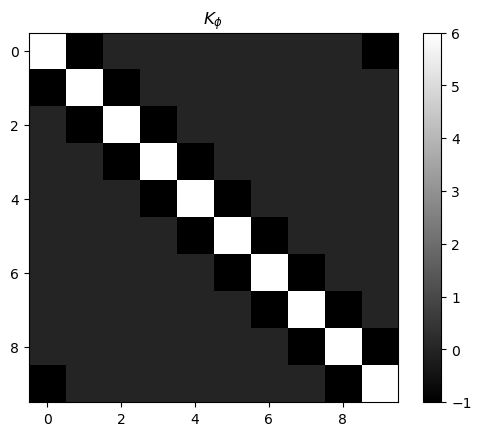

In [95]:
# Trained Kernel
plt.title(r"$K_{\phi}$")
plt.imshow(K_phi, cmap='gray')
plt.colorbar()
plt.show()

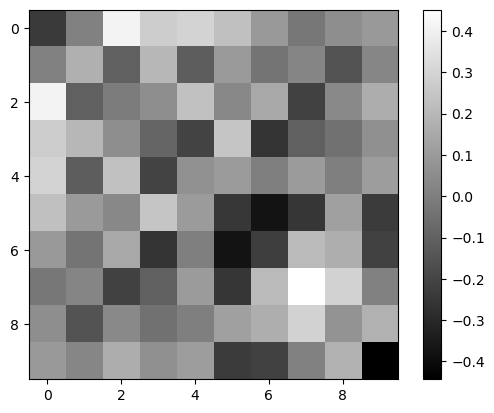

mean:  0.029830997229619512
std:  0.1816497936635006


In [98]:
# Difference between Choleski(initial) solution to the trained solution
diff = K_phi - K
plt.imshow(diff, cmap='gray')
plt.colorbar()
plt.show()

print('mean: ',np.mean(diff))
print('std: ',np.std(diff))

# Compare two-point correlator

In [79]:
n_samples = 1000
init_field = torch.ones((n_samples,N))
regen, regen_, _, _, in_data = rbm.forward(init_field,10)

In [88]:
C_phi = np.linalg.inv(K_phi)
C_rbm_kernel = np.linalg.inv(K)
C_rbm_sample = np.cov(regen_.data.numpy().copy().T)

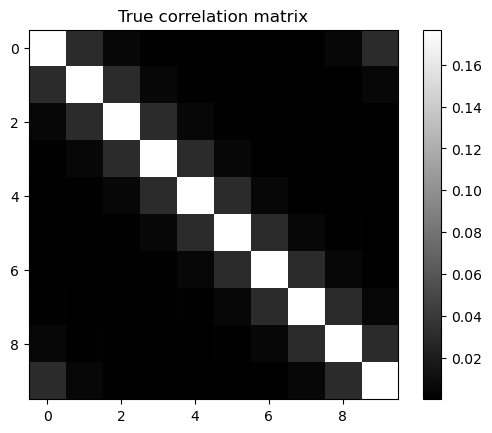

In [89]:
plt.title('True correlation matrix')
plt.imshow(C_phi, cmap='gray')
plt.colorbar()
plt.show()

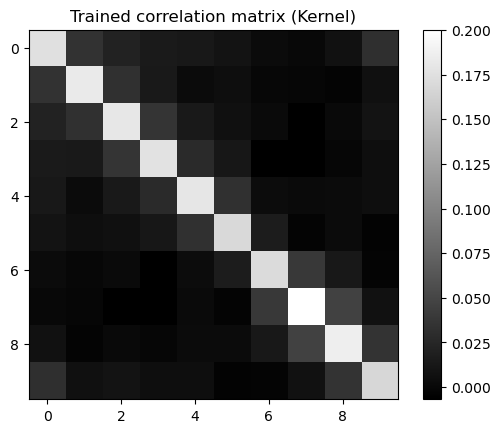

In [90]:
plt.title('Trained correlation matrix (Kernel)')
plt.imshow(C_rbm_kernel, cmap='gray')
plt.colorbar()
plt.show()

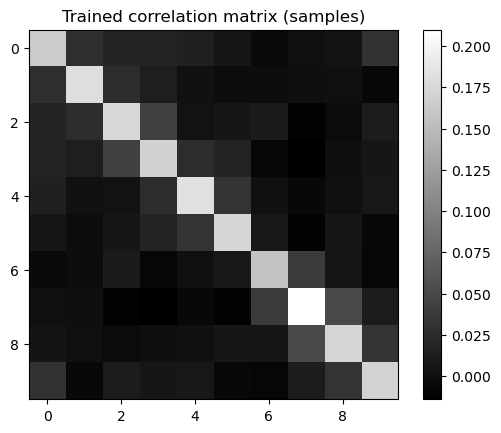

In [91]:
plt.title('Trained correlation matrix (samples)')
plt.imshow(C_rbm_sample, cmap='gray')
plt.colorbar()
plt.show()